#### Code for lstm network development. data preparation for lstm can be found in preprocess/seqdata.ipynb

In [84]:
import pandas as pd
import numpy as np
import keras
from math import ceil
import time
import glob,os
import matplotlib.pyplot as plt
import pickle
import pdb
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Embedding, Masking
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
import tensorflow as tf

In [2]:
#load data
with open('/home/arash/ProjectVR/cleaneddata/seqdata', 'rb') as f:
    allseqdata = pickle.load(f)

X=allseqdata[0]
o1=allseqdata[1]
o2=allseqdata[2]
o3=allseqdata[3]
dist=allseqdata[4]
y=allseqdata[5]

In [32]:
#load data
with open('/home/arash/ProjectVR/cleaneddata/auxdata', 'rb') as f:
    allauxdata = pickle.load(f) 

In [33]:
allauxdata.shape     
# allauxdata columns' corresponding variables:
#'Snowy','Night', 'One way', 'two way', 'Two way with median','Speed Limit_30.0', 
#'Speed Limit_40.0', 'Speed Limit_50.0','Lane Width_2.5', 'Lane Width_2.75', 'Lane Width_3.0',
#'Mean Arrival Rate_530.0', 'Mean Arrival Rate_750.0',
#'Mean Arrival Rate_1100.0'

(3305, 14)

In [59]:
#normalization using min max method: (keras min max not used due to format difference)
#o1,o2,o3: are already bw 0 and 1
maxTraj=[]
minTraj=[]
mindist=[]
for i in range(len(X)):                              #findimg max and min of each feature
    maxTraj.append(max((max(X[i]),max(y[i]))))
    minTraj.append(min((min(X[i]),min(y[i]))))
    mindist.append(min((min(dist[i]),min(dist[i]))))
    
    
maxXY=max(maxTraj)
maxdist=100
minXY=min(minTraj)
mindist=min(mindist)
Xscaled=[]
yscaled=[]
distscaled=[]
for i in range(len(X)):
    Xscaled.append((X[i]-minXY)/(maxXY-minXY))
    yscaled.append((y[i]-minXY)/(maxXY-minXY))
    distscaled.append((np.array(dist[i])-mindist)/(maxdist-mindist))
    

In [ ]:
Xscaled=np.array(Xscaled)
yscaled=np.array(yscaled)
distscaled=np.array(distscaled)

In [68]:
#padding sequences to have same length by adding 0s:
Xscaled = pad_sequences(Xscaled, dtype='float32')       
o1 = pad_sequences(o1,dtype='float32')
o2 = pad_sequences(o2,dtype='float32')
o3 = pad_sequences(o3,dtype='float32')
distscaled = pad_sequences(distscaled,dtype='float32')
yscaled = pad_sequences(yscaled, padding='post',dtype='float32')

In [71]:
# seperate validation data and test set
import random
tst=0.2                 #% if test data
val=0.2                 #% if valid data       
tstsize = int(np.floor(len(X) * tst))
valsize = int(np.floor(len(X) * val))

tstlabel=[]
for i in range(tstsize):
    temp = random.randint(0,X.shape[0]-1)
    tstlabel.append(temp)

In [72]:
Xtest=Xscaled[tstlabel]
o1test=o1[tstlabel]
o2test=o2[tstlabel]
o3test=o3[tstlabel]
disttest=distscaled[tstlabel]
ytest=yscaled[tstlabel]

auxdatatest = allauxdata[tstlabel]

trnlabel=[i for i in range(X.shape[0]) if i not in tstlabel]
trnsize=len(trnlabel)

In [73]:
Xtrain = Xscaled[trnlabel]          #Excluding test set
o1train=o1[trnlabel]
o2train=o2[trnlabel]
o3train=o3[trnlabel]
disttrain=distscaled[trnlabel]
ytrain = yscaled[trnlabel]
auxdatatrain = allauxdata[trnlabel]

In [74]:
vallabel=[]
for i in range(valsize):
    temp = trnlabel[random.randint(0,trnsize-1)]
    vallabel.append(temp)

Xval=Xscaled[vallabel]
o1val=o1[vallabel]
o2val=o2[vallabel]
o3val=o3[vallabel]
distval=distscaled[vallabel]
yval=yscaled[vallabel]
auxdataval=allauxdata[vallabel]

In [75]:
trainlabel=[i for i in range(Xtrain.shape[0]) if i not in [vallabel]]
Xtrain = Xtrain[trainlabel]          #Excluding test set
o1train=o1train[trainlabel]
o2train=o2train[trainlabel]
o3train=o3train[trainlabel]
disttrain=disttrain[trainlabel]
ytrain = ytrain[trainlabel]
auxdatatrain = auxdatatrain[trainlabel]

In [82]:
Xscaled[0][0]

0.0

In [77]:
inputseqTRN=[]
inputseqVAL=[]
inputseqTST=[]

for i in range(Xtrain.shape[0]):
    mrg_input=np.transpose(np.vstack((Xtrain[i],o1train[i],o2train[i],o3train[i],disttrain[i])))
    inputseqTRN.append(mrg_input)
    
for i in range(Xval.shape[0]):
    mrg_input=np.transpose(np.vstack((Xval[i],o1val[i],o2val[i],o3val[i],distval[i])))
    inputseqVAL.append(mrg_input)
    
for i in range(Xtest.shape[0]):
    mrg_input=np.transpose(np.vstack((Xtest[i],o1test[i],o2test[i],o3test[i],disttest[i])))
    inputseqTST.append(mrg_input)  

In [78]:
Xtrain=np.array(inputseqTRN)
Xval=np.array(inputseqVAL)
Xtest=np.array(inputseqTST)

In [80]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = Xtrain[0].shape[1]
n_steps_in=Xtrain.shape[1]
n_steps_out=ytrain.shape[1]

In [88]:
# define vanilla lstm model

model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
history=model.fit(Xtrain, ytrain,
                  epochs=200, verbose=1,batch_size=32,
                  validation_data=(Xval, yval))
                  

Train on 2702 samples, validate on 660 samples
Epoch 1/200
2702/2702 [==============================] - 6s 2ms/step - loss: 0.0225 - val_loss: 0.0155
Epoch 2/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 3/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0145 - val_loss: 0.0145
Epoch 5/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 6/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0142 - val_loss: 0.0148
Epoch 7/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 9/200
2702/2702 [==============================] - 6s 2ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 10/200
2702/2702 [==

2702/2702 [==============================] - 5s 2ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 80/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 81/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 82/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 83/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 84/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 85/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 86/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 87/200
2702/2702 [==============================] - 6s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 88/200
2702/2702 [==============================] - 5s 2ms/step - loss:

2702/2702 [==============================] - 5s 2ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 158/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 159/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 160/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 161/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 162/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 163/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 164/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 165/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 166/200
2702/2702 [==============================] - 5s 2ms/ste

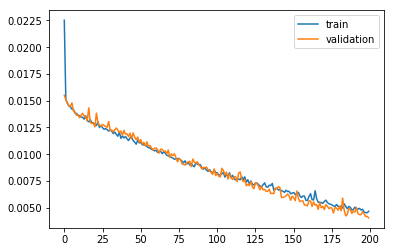

In [89]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [98]:
#inverse normalization using min max method
def norminverse (y,maxXY,minXY):    # function to inverse normalization on predictions
    yinv = np.zeros(y.shape)
    for i in range(len(y)):
        yinv[i]= y[i] * (maxXY-minXY) + minXY
    
    return yinv

In [99]:
# make a prediction on validation set
yhat = model.predict(Xval)
yhatinv = norminverse(yhat,maxXY,minXY)
yvalinv = norminverse(yval,maxXY,minXY)

rmse = sqrt(mean_squared_error(yhatinv, yvalinv))
print('Val RMSE: %.3f' % rmse)

Test RMSE: 0.292


In [102]:
# make a prediction on test set
yhat = model.predict(Xtest)

yhatinv = norminverse(yhat,maxXY,minXY)
ytestinv = norminverse(ytest,maxXY,minXY)

rmse = sqrt(mean_squared_error(yhatinv, ytestinv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.684


## lstm model with aux variables


In [103]:
# sequential input: meant to receive sequence data (inputseq)

seq_input = Input(shape=(n_steps_in, n_features), dtype='float32', name='seq_input')
mask=Masking(mask_value=0.0)(seq_input)
lstm_out = LSTM(50,activation='relu',return_sequences=True)(mask)
lstm_out=LSTM(50, activation='relu')(lstm_out)

#output for lstm, corresponds to 0.2 of loss, used to smooth training and regularization:
auxiliary_output = Dense(n_steps_out, name='aux_output')(lstm_out)   

auxiliary_input = Input(shape=(allauxdata.shape[1],), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(n_steps_out, name='main_output')(x)

model = Model(inputs=[seq_input, auxiliary_input], outputs=[main_output, auxiliary_output])


model.compile(optimizer='adam', loss='mse',
              loss_weights=[1., 0.2])

history=model.fit([Xtrain, auxdatatrain], [ytrain, ytrain],
          epochs=200, batch_size=32,validation_data=([Xval, auxdataval],[yval, yval]))

Train on 2702 samples, validate on 660 samples
Epoch 1/200
2702/2702 [==============================] - 7s 3ms/step - loss: 0.0309 - main_output_loss: 0.0260 - aux_output_loss: 0.0245 - val_loss: 0.0203 - val_main_output_loss: 0.0172 - val_aux_output_loss: 0.0158
Epoch 2/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0190 - main_output_loss: 0.0159 - aux_output_loss: 0.0153 - val_loss: 0.0189 - val_main_output_loss: 0.0158 - val_aux_output_loss: 0.0152
Epoch 3/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0181 - main_output_loss: 0.0151 - aux_output_loss: 0.0149 - val_loss: 0.0180 - val_main_output_loss: 0.0151 - val_aux_output_loss: 0.0149
Epoch 4/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0175 - main_output_loss: 0.0146 - aux_output_loss: 0.0148 - val_loss: 0.0178 - val_main_output_loss: 0.0148 - val_aux_output_loss: 0.0148
Epoch 5/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0172 -

2702/2702 [==============================] - 6s 2ms/step - loss: 0.0135 - main_output_loss: 0.0111 - aux_output_loss: 0.0121 - val_loss: 0.0129 - val_main_output_loss: 0.0105 - val_aux_output_loss: 0.0121
Epoch 39/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0135 - main_output_loss: 0.0111 - aux_output_loss: 0.0121 - val_loss: 0.0131 - val_main_output_loss: 0.0107 - val_aux_output_loss: 0.0120
Epoch 40/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0130 - main_output_loss: 0.0107 - aux_output_loss: 0.0118 - val_loss: 0.0123 - val_main_output_loss: 0.0100 - val_aux_output_loss: 0.0116
Epoch 41/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0132 - main_output_loss: 0.0109 - aux_output_loss: 0.0119 - val_loss: 0.0127 - val_main_output_loss: 0.0104 - val_aux_output_loss: 0.0118
Epoch 42/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0127 - main_output_loss: 0.0104 - aux_output_loss: 0.0117 - v

Epoch 76/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0091 - main_output_loss: 0.0072 - aux_output_loss: 0.0098 - val_loss: 0.0087 - val_main_output_loss: 0.0068 - val_aux_output_loss: 0.0093
Epoch 77/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0093 - main_output_loss: 0.0073 - aux_output_loss: 0.0100 - val_loss: 0.0090 - val_main_output_loss: 0.0071 - val_aux_output_loss: 0.0095
Epoch 78/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0091 - main_output_loss: 0.0072 - aux_output_loss: 0.0099 - val_loss: 0.0088 - val_main_output_loss: 0.0070 - val_aux_output_loss: 0.0092
Epoch 79/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0089 - main_output_loss: 0.0070 - aux_output_loss: 0.0097 - val_loss: 0.0085 - val_main_output_loss: 0.0066 - val_aux_output_loss: 0.0095
Epoch 80/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0091 - main_output_loss: 0.0071 - aux_output_los

2702/2702 [==============================] - 5s 2ms/step - loss: 0.0066 - main_output_loss: 0.0049 - aux_output_loss: 0.0086 - val_loss: 0.0058 - val_main_output_loss: 0.0042 - val_aux_output_loss: 0.0080
Epoch 114/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0065 - main_output_loss: 0.0048 - aux_output_loss: 0.0084 - val_loss: 0.0055 - val_main_output_loss: 0.0040 - val_aux_output_loss: 0.0076
Epoch 115/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0064 - main_output_loss: 0.0047 - aux_output_loss: 0.0084 - val_loss: 0.0062 - val_main_output_loss: 0.0047 - val_aux_output_loss: 0.0079
Epoch 116/200
2702/2702 [==============================] - 6s 2ms/step - loss: 0.0064 - main_output_loss: 0.0047 - aux_output_loss: 0.0084 - val_loss: 0.0058 - val_main_output_loss: 0.0042 - val_aux_output_loss: 0.0079
Epoch 117/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0065 - main_output_loss: 0.0048 - aux_output_loss: 0.0084

2702/2702 [==============================] - 5s 2ms/step - loss: 0.0051 - main_output_loss: 0.0035 - aux_output_loss: 0.0076 - val_loss: 0.0046 - val_main_output_loss: 0.0031 - val_aux_output_loss: 0.0074
Epoch 151/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0050 - main_output_loss: 0.0035 - aux_output_loss: 0.0076 - val_loss: 0.0043 - val_main_output_loss: 0.0029 - val_aux_output_loss: 0.0069
Epoch 152/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0049 - main_output_loss: 0.0034 - aux_output_loss: 0.0075 - val_loss: 0.0043 - val_main_output_loss: 0.0029 - val_aux_output_loss: 0.0070
Epoch 153/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0050 - main_output_loss: 0.0035 - aux_output_loss: 0.0075 - val_loss: 0.0040 - val_main_output_loss: 0.0026 - val_aux_output_loss: 0.0070
Epoch 154/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0048 - main_output_loss: 0.0033 - aux_output_loss: 0.0076

2702/2702 [==============================] - 5s 2ms/step - loss: 0.0040 - main_output_loss: 0.0026 - aux_output_loss: 0.0069 - val_loss: 0.0033 - val_main_output_loss: 0.0021 - val_aux_output_loss: 0.0061
Epoch 188/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0041 - main_output_loss: 0.0027 - aux_output_loss: 0.0070 - val_loss: 0.0033 - val_main_output_loss: 0.0021 - val_aux_output_loss: 0.0060
Epoch 189/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0039 - main_output_loss: 0.0025 - aux_output_loss: 0.0068 - val_loss: 0.0034 - val_main_output_loss: 0.0021 - val_aux_output_loss: 0.0062
Epoch 190/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0039 - main_output_loss: 0.0025 - aux_output_loss: 0.0068 - val_loss: 0.0032 - val_main_output_loss: 0.0020 - val_aux_output_loss: 0.0062
Epoch 191/200
2702/2702 [==============================] - 5s 2ms/step - loss: 0.0039 - main_output_loss: 0.0026 - aux_output_loss: 0.0068

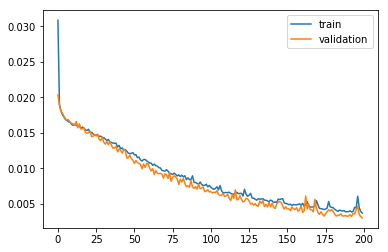

In [104]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [105]:
# make a prediction
yhat=model.predict([Xval,auxdataval])
yhatinv = norminverse(yhat[0],maxXY,minXY)
yvalinv = norminverse(yval,maxXY,minXY)

rmse = sqrt(mean_squared_error(yhatinv, yvalinv))
print('Val RMSE: %.3f' % rmse)

Val RMSE: 0.197


In [106]:
# make a prediction on test set
yhat=model.predict([Xtest,auxdatatest])
yhatinv = norminverse(yhat[0],maxXY,minXY)
ytestinv = norminverse(ytest,maxXY,minXY)

rmse = sqrt(mean_squared_error(yhatinv, ytestinv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.616


# Comparing model performac for RMSE of the validation set, 
### all models are trained on same training and validation set, over 200 epochs,
###### (Dense mentioned in models are hidden layers, output dense layer not counted
* **Vanilla 1**: Batch size=32, LSTM units=50,No Masking input, no sample weights for output, two LSTM layer, loss=mse, **RMSE=~71** 

* **Vanilla 2:** Batch size=32, LSTM units=50, Masking input, no sample weights for output, two LSTM layer, loss=mse, **VAL RMSE=~0.29, Test RMSE=0.684**

* **AuxLSTM 1:** Batch size=32, LSTM units=50, Masking input, no sample weights for output, two LSTM layers, , one hidden dense, loss=mse, **VAL RMSE=~0.197, Test RMSE=0.616**
